In [1]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [2]:
# files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #filepath for multi, this is a directory containing directories.
files = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\Visual Studio 2010\Projects\Lubin Lab\Data\sn2023ixf\sn2023ixf_r\*")) #filepath for multi, this is a directory containing directories.
data = []
for i, dir in enumerate(files):
    # print(i)
    set = dict(images = [], header = None, template = None, refs = None, WCS = None, run = i) #dictionary object used to sort input files
    images = sorted(glob.glob(dir+'/*')) # formatting
    # print(dir)
    hdus = [fits.open(i) for i in images] #opens fits files
    frames = [h[1].data for h in hdus] #image data

    header = (hdus[0])[1].header #the header for each run is the header for the first image, you don't need each individual header.
    try: #some datsets won't align, this is not ideal but we can skip alignment.
        aligned = [aa.register(i, frames[0])[0] for i in frames[0:]] #align takes quite a while, is there a way to make it faster?
    except:
        aligned = frames
        print("DID NOT ALIGN")

    template = np.median(aligned, axis = 0) #creates median value template
    w = WCS(hdus[0][1].header) #WCS matrix object, used to transform pixel values to RA-DEC coordinates
    print(w)
    print(type(w))
    print(np.shape(w))


    #Fills out set object
    set['images'] = aligned
    set['header'] = header
    set['template'] = template
    set['WCS'] = w
    bkg_phot = sep.Background(template) #background subtract for source extraction.
    set['refs'] = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image
     #this ensures that the source list is the same for all sets
    set['run'] = i
    print(len(set['refs'])) #check
    data.append(set)
#added


Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.037737423  54.2239939254  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -1.29364676869e-06  0.000158494481656  
CD2_1 CD2_2  : -0.000158494481656  -1.29364676869e-06  
NAXIS : 3054  2042
<class 'astropy.wcs.wcs.WCS'>
()
71


Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.049145965  54.2290174565  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -3.55588006181e-06  0.00015851448458  
CD2_1 CD2_2  : -0.00015851448458  -3.55588006181e-06  
NAXIS : 3054  2042
<class 'astropy.wcs.wcs.WCS'>
()
90
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.035359468  54.2259746409  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -1.27772956067e-06  0.000158500477611  
CD2_1 CD2_2  : -0.000158500477611  -1.27772956067e-06  
NAXIS : 3054  2042
<class 'astropy.wcs.wcs.WCS'>
()
70
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.043778602  54.2272209867  
CRPIX : 1527.5  1021.5  
CD1_1 CD1_2  : -3.5546821071e-06  0.000158493590858  
CD2_1 CD2_2  : -0.000158493590858  -3.5546821071e-06  
NAXIS : 3054  2042
<class 'astropy.wcs.wcs.WCS'>
()
83
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 211.05004839  54.2290506116  


In [3]:
print(len(data)) #check

10


In [4]:
#This section access SDSS to collect reference magnitudes for our sources.

sources = []
n_ref = 0 #check counter
filter = 'r' #observation filter
for c, src in enumerate(data[0]['refs']): #looking at the sources picked out in the first run so that everything is with respect to one source list.
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, data[0]['WCS']).transform_to('icrs') #gives wcs transformation for pixel coordinates
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_{}'.format(filter), 'psfMagErr_{}'.format(filter)], radius = 15 * u.arcsec, region = False) #narrow field cone search to find source based on ra, dec.
    radius = (src['xmax']-src['xmin'])/2
    ref = dict(ra_dec = coord, source_id = c, rad = radius, ref_mag = None, ref_mag_err = None, border = False) #because the pixel value isn't static across observing runs, don't save the x-y values just ra dec and convert later.
    for i in range(0, len(data)): #creates mag slots for each observing run
        ref['calibrated_mags_{}'.format(i)] = [] #even though the calibrated mags should line up (and not need to be separated) this is to help visualize day changes later on
        ref['instrumental_mags_{}'.format(i)] = []
        ref['inst_mag_errs_{}'.format(i)] = []
    if search: #if SDSS query returned results, continue
        if search['type'] == 'STAR': #filters search results by sources that of type star.
            ref['ref_mag'] = search['psfMag_{}'.format(filter)] #add reference mag
            ref['ref_mag_err'] = search['psfMagErr_{}'.format(filter)] #add SDSS error
            n_ref += 1
    sources.append(ref)
print(n_ref)
#added

26


In [5]:
print(sources[0]) #just to check everything is there.
print(len(data[0]))

{'ra_dec': <SkyCoord (ICRS): (ra, dec) in deg
    (210.7632998, 54.15153201)>, 'source_id': 0, 'rad': 5.5, 'ref_mag': None, 'ref_mag_err': None, 'border': False, 'calibrated_mags_0': [], 'instrumental_mags_0': [], 'inst_mag_errs_0': [], 'calibrated_mags_1': [], 'instrumental_mags_1': [], 'inst_mag_errs_1': [], 'calibrated_mags_2': [], 'instrumental_mags_2': [], 'inst_mag_errs_2': [], 'calibrated_mags_3': [], 'instrumental_mags_3': [], 'inst_mag_errs_3': [], 'calibrated_mags_4': [], 'instrumental_mags_4': [], 'inst_mag_errs_4': [], 'calibrated_mags_5': [], 'instrumental_mags_5': [], 'inst_mag_errs_5': [], 'calibrated_mags_6': [], 'instrumental_mags_6': [], 'inst_mag_errs_6': [], 'calibrated_mags_7': [], 'instrumental_mags_7': [], 'inst_mag_errs_7': [], 'calibrated_mags_8': [], 'instrumental_mags_8': [], 'inst_mag_errs_8': [], 'calibrated_mags_9': [], 'instrumental_mags_9': [], 'inst_mag_errs_9': []}
6


In [6]:
for set in data:
    print(set['run'])
    for i, image in enumerate(set['images']):
        print(i)
        N_r = set['header']['RDNOISE'] #readout noise
        for source in sources:
            coords = SkyCoord.to_pixel(source['ra_dec'], wcs = set['WCS']) #gets pixel values of source from RA DEC
            #print(coords[0], coords[1])
            if (set['header']['NAXIS1'] - coords[0]) < 0 or coords[0] < 0 or (set['header']['NAXIS2'] - coords[1]) < 0 or coords[1] < 0: #checks to see if a source exceeds image boundaries for later image sets.
                source['border'] = True
                print(source['source_id'], coords[0], coords[1])
                continue

            pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions
            radius_i = source['rad']
            radius_o_0 = radius_i + 5 #inner annulus radius
            radius_o_1 = radius_o_0 + 5 #outer annulus radius

            source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
            source_aperture = source_circle.cutout(image) #gets data of source

            background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
            background_mean = ApertureStats(image, background_annulus).mean

            source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
            source_flux_total = np.sum(source_flux_pix) #total flux

            readout_sum_square = np.sum(source_circle*np.float64(N_r**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

            delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(image, background_annulus)['aperture_sum'][0]))**(1/2) #this is the stuff for SNR

            good = 0
            bad = 0
            if source_flux_total <= 0:
                bad += 1
                print("NEGATIVE PIXELS", source['source_id'])
                inst_mag = -2.5*np.log10(abs(source_flux_total)) # For now, the case where the background is oversubtracted from LCO is handled in this way but this is probably not the correct way to do this.
                delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total) #magnitude error

            else:
                inst_mag = -2.5*np.log10(source_flux_total)
                delta_m = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
            source['instrumental_mags_{}'.format(set['run'])].append(inst_mag)
            source['inst_mag_errs_{}'.format(set['run'])].append(delta_m)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
0
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
1
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
2
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
3
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
4
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
5
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
6
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
7
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
8
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
9
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
10
0 2036.6212984916306 -24.137704964576415
59 3077.256756264475 1380.390513724957
11
0 2036.6212984916306 -24.

In [7]:
count = 0 #just another check, this part isn't necessary
for source in sources:
    if len(source['instrumental_mags_0']) > 0:
        print(source['ref_mag'])
        count += 1
print(count)

None
None
None
None
None
None
None
None
None
None
None
None
None
psfMag_r
--------
14.14103
None
None
None
psfMag_r
--------
16.39703
psfMag_r
--------
17.44732
None
None
None
psfMag_r
--------
13.74609
psfMag_r
--------
14.09081
None
psfMag_r
--------
14.91957
None
psfMag_r
--------
15.02432
None
None
None
None
None
None
None
None
None
None
psfMag_r
--------
16.40927
psfMag_r
--------
11.62752
None
None
psfMag_r
--------
  14.504
None
psfMag_r
--------
15.32855
None
None
psfMag_r
--------
14.47984
None
psfMag_r
--------
15.95399
psfMag_r
--------
 23.4499
None
psfMag_r
--------
 13.2153
None
None
None
None
psfMag_r
--------
14.16824
None
psfMag_r
--------
16.33758
None
psfMag_r
--------
 15.9441
None
psfMag_r
--------
13.37774
psfMag_r
--------
9.829223
psfMag_r
--------
16.35837
psfMag_r
--------
15.40109
psfMag_r
--------
16.35447
psfMag_r
--------
14.42296
psfMag_r
--------
16.30494
psfMag_r
--------
16.55701
71


12 12
first try: [ 0.93901199 23.39383052]
second try: [ 0.93207118 23.25174687]


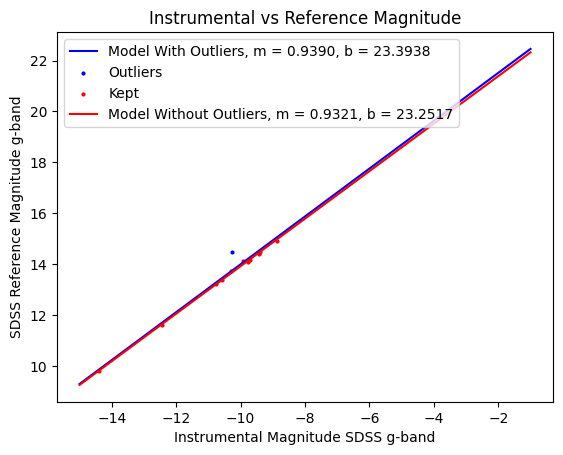

12 12
first try: [ 0.99034297 24.33115144]
second try: [ 0.98296518 24.18170362]


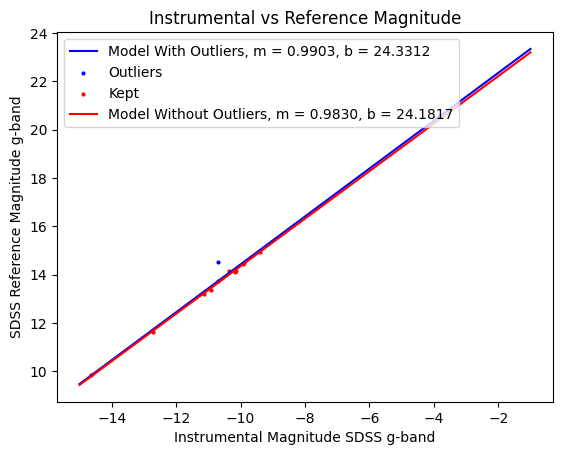

12 12
first try: [ 0.94510224 23.49632793]
second try: [ 0.93843756 23.35575379]


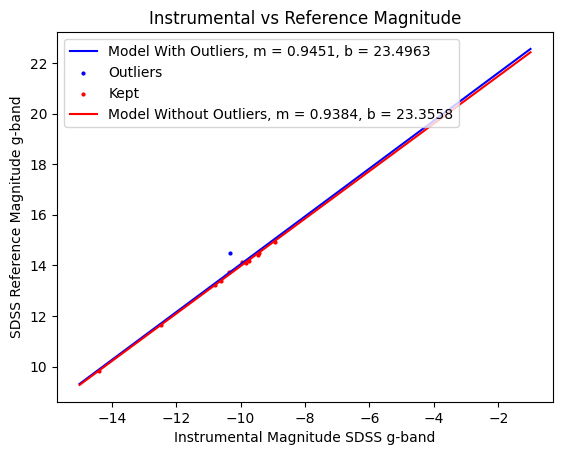

12 12
first try: [ 0.95652145 23.85360618]
second try: [ 0.95025581 23.71411231]


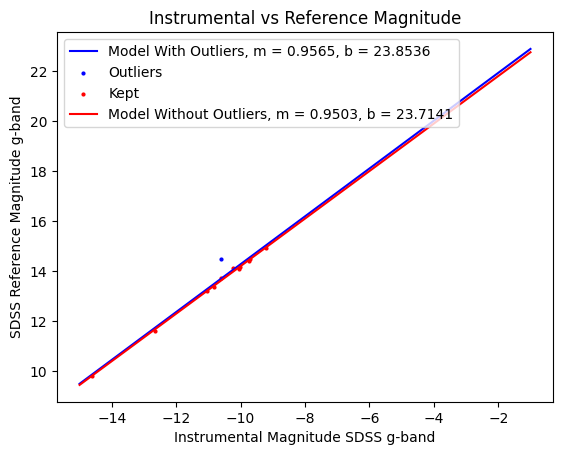

12 12
first try: [ 0.98263106 24.21284627]
second try: [ 0.97580626 24.06802445]


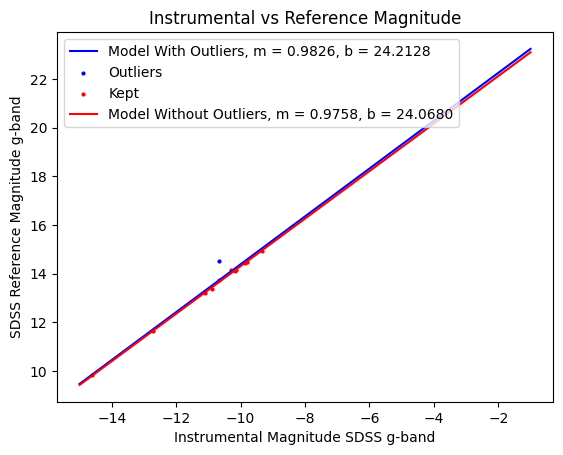

12 12
first try: [ 0.98005156 23.97686032]
second try: [ 0.97255515 23.82866013]


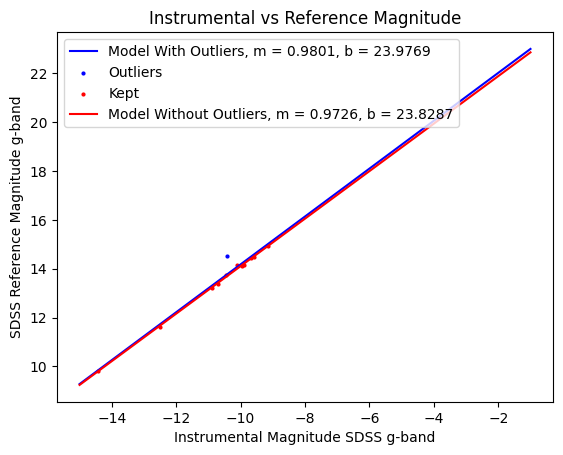

12 12
first try: [ 0.9530257 23.5736372]
second try: [ 0.94542732 23.42643753]


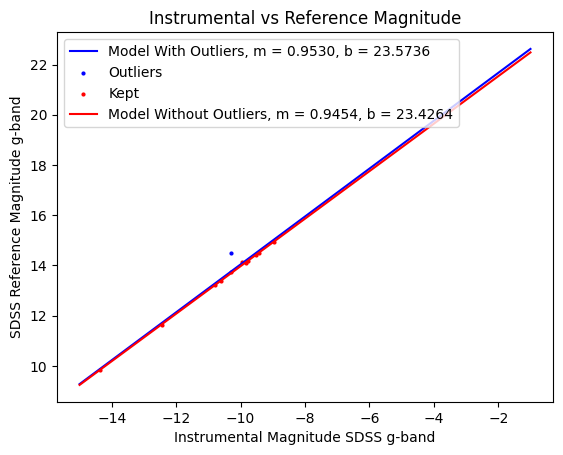

12 12
first try: [ 0.9477386  23.53443289]
second try: [ 0.94047528 23.38952413]


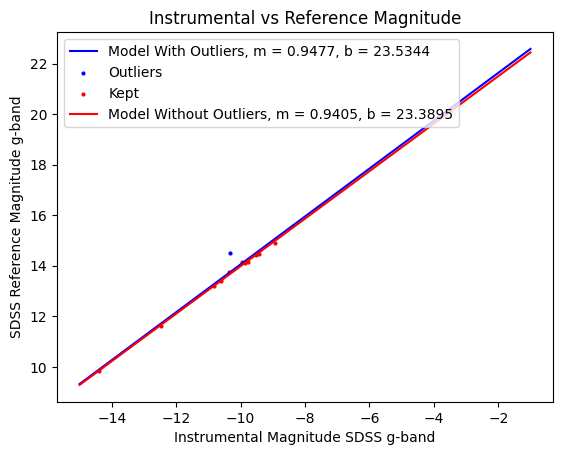

12 12
first try: [ 0.95555892 23.62891945]
second try: [ 0.9481832  23.48292253]


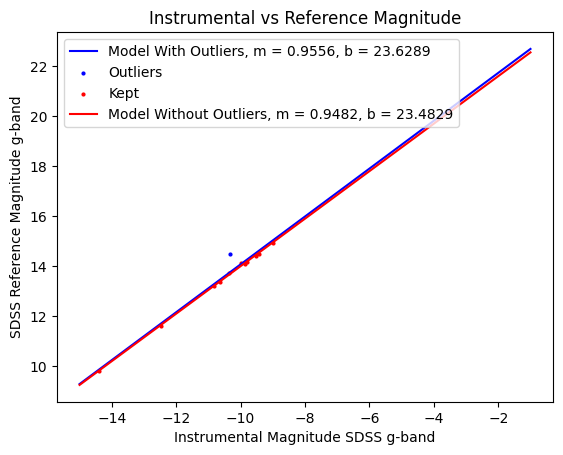

12 12
first try: [ 0.95267602 23.56440779]
second try: [ 0.9455761  23.42065721]


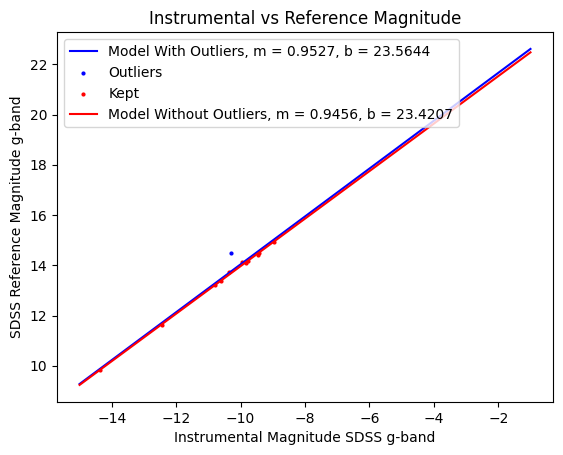

In [8]:
#NEED TO PROPAGATE ERROR FROM THIS SECTION

for set in data:
    res = []
    mag_thresh = 15 #magnitude threshold for picking reference stars

    #criteria for reference stars are that they have an SDSS reference mag, are brighter than the mag threshold and are not outside of the image
    inst_mags = [np.mean(source['instrumental_mags_{}'.format(set['run'])]) for source in sources if source['ref_mag'] != None and source['ref_mag'] < mag_thresh and source['border'] == False]
    sky_mags = [source['ref_mag'][0] for source in sources if source['ref_mag'] != None and source['ref_mag'] < mag_thresh and source['border'] == False]
    #Makes linear model for calibration:
    #This is the first round of modeling, with outliers.
    print(len(inst_mags), len(sky_mags))
    p0 = np.polyfit(inst_mags, sky_mags, deg = 1) #linear fit for instrumental to SDSS mags
    x = np.arange(-15, 0) #plotting fit line
    y = p0[0]*x + p0[1] #fit line
    plt.plot(x, y, color = 'b', label = "Model With Outliers, m = {}, b = {}".format("%.4f" % p0[0], "%.4f" % p0[1] ))
    diffs = [s['ref_mag'][0]- (np.mean(s['instrumental_mags_{}'.format(set['run'])])*p0[0] + p0[1]) for s in sources if s['ref_mag'] != None and s['ref_mag'] < mag_thresh and s['border'] == False]
    stdv = np.std(diffs)

    inst_mags_final = []
    sky_mags_final = []
    outlier_inst =[]
    outlier_sky =[]

    for diff in diffs: #rudementary sigma clipping to remove outliers from calibration model.
        if diff < stdv:
            i = diffs.index(diff)
            inst_mags_final.append(inst_mags[i])
            sky_mags_final.append(sky_mags[i])
        else:
            i = diffs.index(diff)
            outlier_inst.append(inst_mags[i])
            outlier_sky.append(sky_mags[i])
    p1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1) #recalculates calibration model without outliers.
    #p2 = np.polyfit(inst_mags_final, sky_mags_final, deg = 0)
    #print(p2[0])
    print("first try: {}".format(p0)) #prints slopes of each model. In theory, they should come out to around 1.
    print("second try: {}".format(p1))


    plt.scatter(outlier_inst, outlier_sky, color = 'b', s = 4, label = "Outliers")
    plt.scatter(inst_mags_final, sky_mags_final, color = 'r', s = 4, label = "Kept")
    plt.plot(x, [i*p1[0] + p1[1] for i in x], color = 'r', label = "Model Without Outliers, m = {}, b = {}".format("%.4f" % p1[0], "%.4f" % p1[1]))
    #plt.plot(x, [i+ p1[1] for i in x], color = 'g', label = "unity")
    plt.xlabel("Instrumental Magnitude SDSS g-band")
    plt.ylabel("SDSS Reference Magnitude g-band")
    plt.title("Instrumental vs Reference Magnitude")
    plt.legend()
    #plt.savefig("F:/SDI/Section32Figures/calibrationplot.png", dpi = 1000)
    # plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/calibrationplot.png", dpi = 1000)
    plt.show()



    #add calibrated mags to sources:
    for source in sources:
        vals = []
        for val in source['instrumental_mags_{}'.format(set['run'])]:
            cal = np.float64(val*p1[0] + p1[1])
            vals.append(cal)
        source['calibrated_mags_{}'.format(set['run'])] = vals #probably a cleaner way to do this part but was having issue where calibrated magnitudes were being added to dict as individual arrays

0
0.39140999622202494 -0.03256621899137002 1.8898257113788375
[[ 1.00744665]
 [-0.03106402]]


c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1094: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1095: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


50


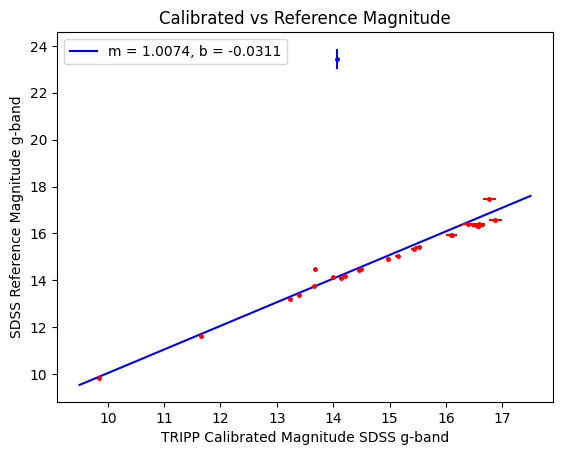

1
0.441999547042419 -0.012499726508100828 1.875756044445134
[[ 1.00750565]
 [-0.03205161]]
50


c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1092: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1093: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
c:\Users\Sam Whitebook\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1172: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\Sam

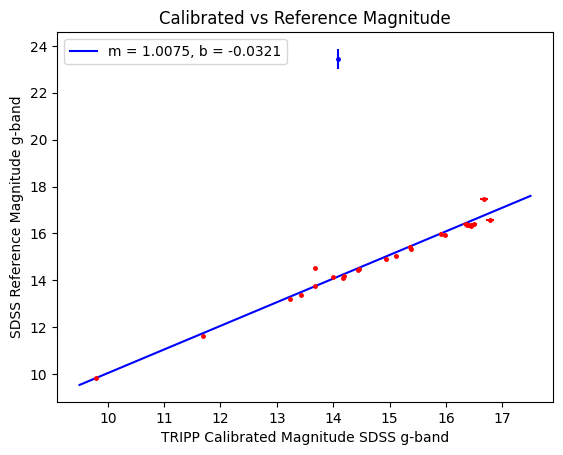

2
0.3948837084547691 -0.038023833570957954 1.8892152670601605
[[ 1.00710189]
 [-0.0252958 ]]
50


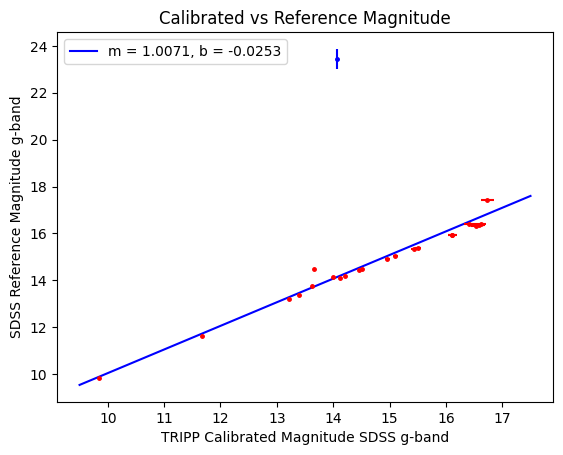

3
0.3521854101348055 -0.05359962310544031 1.9025433315642857
[[ 1.00659364]
 [-0.01686842]]
50


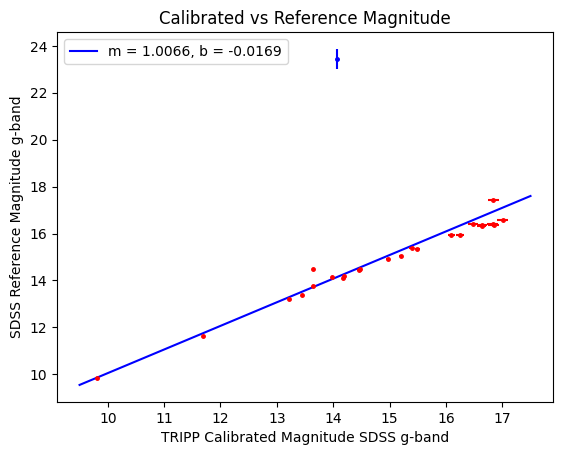

4
0.42195297900345285 -0.02972960651573242 1.8798181292578393
[[ 1.006994  ]
 [-0.02351001]]
50


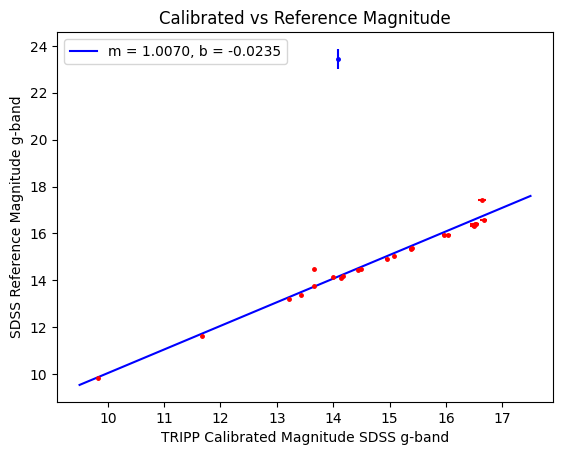

5
0.4542849997482698 -0.019295079634917833 1.875343706574293
[[ 1.00770795]
 [-0.03546988]]
50


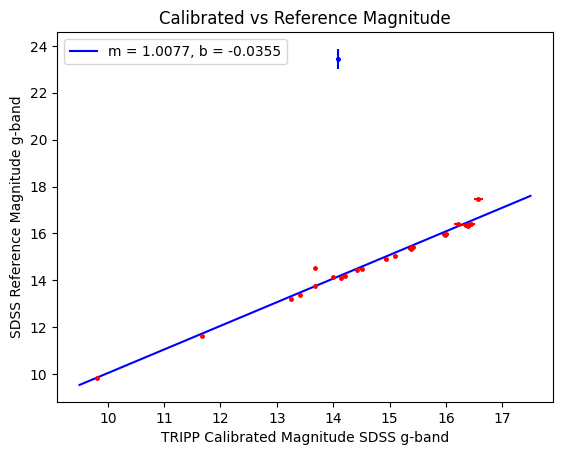

6
0.4012038378133958 -0.03226372411284206 1.8891171069621242
[[ 1.00803698]
 [-0.04107807]]
50


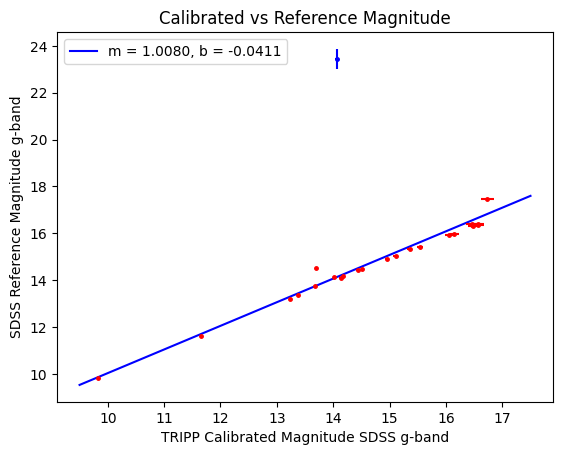

7
0.4025667913839644 -0.026284202266237955 1.8874907035374566
[[ 1.00772303]
 [-0.03572921]]
50


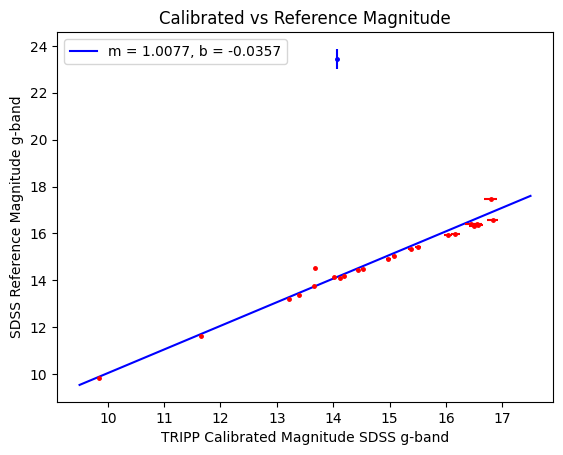

8
0.40974976701453475 -0.02851515074957245 1.8855317769838522
[[ 1.0077788 ]
 [-0.03667193]]
50


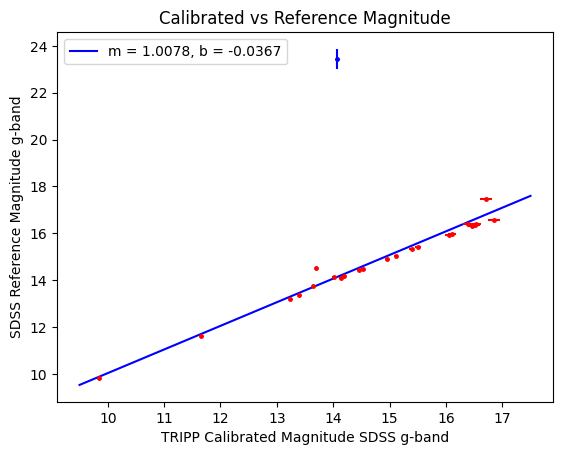

9
0.3937817758727173 -0.042255424406511644 1.8885758006811872
[[ 1.00750856]
 [-0.0321048 ]]
50


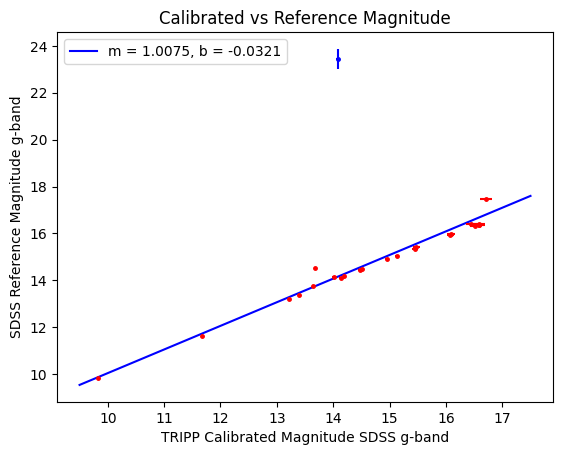

In [9]:
#more plotting just to check stuff, not really necessary for final pipeline but nice to have
for set in data:
    print(set['run'])
    differences = [s['ref_mag']- np.mean(s['calibrated_mags_{}'.format(set['run'])]) for s in sources if s['ref_mag'] != None and s['border'] == False]
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    med_diff = np.median(differences)
    print(mean_diff, med_diff,  std_diff)

    X = [np.mean(s['calibrated_mags_{}'.format(set['run'])]) for s in sources if s['ref_mag'] != None and s['ref_mag'] < mag_thresh and s['border'] == False]
    Y = [s['ref_mag'] for s in sources if s['ref_mag'] != None and s['ref_mag'] < mag_thresh and s['border'] == False]
    p3 = np.polyfit(X, Y, deg = 1)
    x_vals = np.arange(9.5, 18.5)
    plt.plot(x_vals, [x*p3[0] + p3[1] for x in x_vals], color = 'b', label = 'm = {}, b = {}'.format("%.4f" % p3[0], "%.4f" % p3[1]))


    print(p3)

    for s in sources:
        if s['ref_mag'] != None and abs(s['ref_mag'] - np.mean(s['calibrated_mags_{}'.format(set['run'])])) > 3*std_diff:
            plt.errorbar(np.mean(s['calibrated_mags_{}'.format(set['run'])]), s['ref_mag'], xerr= np.median(s['inst_mag_errs_{}'.format(set['run'])]), yerr= s['ref_mag_err'], linestyle = 'none', marker = 'o', markersize = 2.5, color = 'b')
            print(s['source_id'])
        else:
            plt.errorbar(np.mean(s['calibrated_mags_{}'.format(set['run'])]), s['ref_mag'], xerr= np.median(s['inst_mag_errs_{}'.format(set['run'])]), yerr= s['ref_mag_err'], linestyle = 'none', marker = 'o', markersize = 2.5, color = 'r' )



    plt.title("Calibrated vs Reference Magnitude")
    plt.xlabel("TRIPP Calibrated Magnitude SDSS g-band")
    plt.ylabel("SDSS Reference Magnitude g-band")
    plt.legend()
    # plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/magdifferences.png", format = 'png', dpi = 1000)
    plt.show()

In [10]:
runs = np.arange(0, len(data))
colors = []
for run in runs: #sets up color scheme for plotting.
    i = 0
    for val in sources[0]['calibrated_mags_{}'.format(run)]:
        i += 1
        colors.append(run)
    print(i)
c = np.array(colors)
colors_options = np.array(['#3B5BA5', '#E87A5D', '#F3B941', '#f00a42', '#6F9BA4', '#9D9EA2', "#C5E86C", "#B4B5DF"]) #HEXIDECIMAL COLORS need to add a ton of colors to this even if they don't all get used. Could set it up do randomly generate hex colors but that will be inconsistent and kinda look like shit.

25
0
25
0
0
25
25
25
0
25


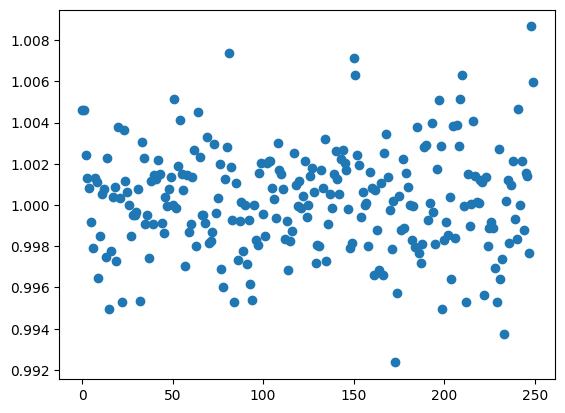

In [14]:
mode = 0
med_dev = True
if med_dev == True: #only run this for single night observing runs. Make part of each night?
    median_curves = []
    for i, run in enumerate(runs):
        median_mags = []
        for source in sources:
            if source['border'] == False:
                median_mags.append([source[f'calibrated_mags_{i}']])
        median_curve = np.median(median_mags, axis = 0)/np.median(median_mags) #normalized median light curve
        median_curves.append(median_curve)
    curve = np.concatenate(median_curves)
med_curve_final = np.concatenate(curve)
p = np.arange(0, len(med_curve_final))
plt.scatter(p, med_curve_final)
plt.show()

In [15]:
print(type(data[0]['header']['DAY-OBS']))

<class 'str'>


In [16]:
transient_candidates = []
#plots light curves.
for source in sources:
    x, y = SkyCoord.to_pixel(source['ra_dec'], wcs= data[0]['WCS'])
    tick_locs = []
    if mode == 0:
        MAGS = np.concatenate([source['calibrated_mags_{}'.format(i)] for i in runs if source['border'] == False])
        ERRS = np.concatenate([source['inst_mag_errs_{}'.format(i)] for i in runs if source['border'] == False])
        r = np.arange(0, len(MAGS), 1)
        set_counter = 0
        for i, val in enumerate(MAGS):
            if len(data) > 1 and i % len(data[set_counter]['images']) == 0: #THIS WILL ONLY WORK IF ALL SETS HAVE 25 FRAMES. Need to make it dynamic in case different nights don't have the same number of images.
                print(len(data[set_counter]['images']))
                plt.errorbar(i, val/med_curve_final[i], yerr = ERRS[i], linestyle = 'none', marker = 'o', markersize = 4,  c = colors_options[c][i])
                tick_locs.append(i)
                if set_counter < len(data) -1: #prevents counter from over indexing data
                    set_counter += 1
            else:
                plt.errorbar(i, val/med_curve_final[i], yerr = ERRS[i], linestyle = 'none', marker = 'o', markersize = 4, c = colors_options[c][i])
        if len(data) > 1:
            plt.xticks(tick_locs, [data[i]['header']['DAY-OBS'] for i in runs], rotation = 20)


    if mode == 1:
        MAGS = [np.median(source['calibrated_mags_{}'.format(i)]) for i in runs if source['border'] == False]
        ERRS = [np.median(source['inst_mag_errs_{}'.format(i)]) for i in runs if source['border'] == False]
        r = np.arange(0, len(MAGS), 1)
        for i, mag in enumerate(MAGS):
            plt.errorbar(i, mag, yerr = ERRS[i], linestyle = 'none', marker = 'o', markersize = 4, c = colors_options[r][i])
            tick_locs.append(i)
        plt.xticks(tick_locs, [data[i]['header']['DAY-OBS'] for i in runs], rotation = 20)

    Chis = []
    avg_mag = np.mean(MAGS/med_curve_final)
    for i, m in enumerate(MAGS):
        chi_i = (((m/med_curve_final[i]) - avg_mag)**2)/(ERRS[i]**2)
        Chis.append(chi_i)
    dof = len(MAGS) - 1
    chi_dof = np.sum(Chis)/dof

    #transient/variable detection:
    dev = np.std(MAGS/med_curve_final)
    print(dev)


    #plt.title("X, Y: {}, {}; RA, DEC: {}, {}, CHI2: {}, ID: {}".format("%.2f" % source['x_coord'],"%.2f" % source['y_coord'],"%.4f" % source['ra'][0],"%.4f" % source['dec'][0], "%.2f" %chi_dof, source['source_id'] )) #get only to display a few decimal places
    plt.title("X, Y: {}, {}; RA_DEC: {}; CHI2: {}, ID: {}".format("%.2f" % x,"%.2f" % y, source['ra_dec'], "%.2f" %chi_dof, source['source_id'] ))
    plt.plot(r, np.ones(len(r))*avg_mag, label = "TRIPP AVG MAG", linestyle = '--', color = 'b')
    if source['ref_mag'] != None:
        if source['ref_mag'] < 16:
            plt.plot(r, np.ones(len(r))*source['ref_mag'], linestyle = '--', color = 'r', label = "SDSS MAG [REF]" )
        if source['ref_mag'] >= 16:
            plt.plot(r, np.ones(len(r))*source['ref_mag'], linestyle = '--', color = 'g', label = "SDSS MAG [NOT REF]" )
    plt.ylabel("TRIPP Magnitude, SDSS-{}'".format(filter))
    plt.xlabel("Observation Date YYYY/MM/DD")
    plt.legend()
    #plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/Source{}lightcurve.png".format(source['source_id']), format = 'png', dpi = 500,  bbox_inches="tight")
    plt.gca().invert_yaxis()
    plt.show()



    plt.title("Source Number: {}, Position: {}, {}".format(source['source_id'], "%.2f" % x, "%.2f" % y))
    circle0 = plt.Circle((x, y), source['rad'], color = 'r', fill = False)
    circle1 = plt.Circle((x, y), source['rad'] + 5, color = 'b', fill = False)
    circle2 = plt.Circle((x,y), source['rad'] +5, color = 'g',fill = False)
    ax = plt.gca()
    ax.add_patch(circle0)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    plt.imshow(data[0]['template'], cmap = 'gray', norm = LogNorm(vmin = 1, vmax = 200), origin='lower')
    #plt.savefig("/Users/lucaangeleri/Documents/LCO/SN2023ixf_r_plots/Source{}location.png".format(source['source_id']), format = 'png', dpi = 500,  bbox_inches="tight")
    plt.show()


ValueError: need at least one array to concatenate